# Problem Statement

<font color=darkblue>In business, it is crucial to understand customers'needs and desire in order to provide optimize their customer journey and maximize their potential value to our business. In order to do so, we firstly need to segment our customers into groups that share something in common. With that, only we are able to curate products and services that cater to their needs.<br><br>
Conventional method practice of customer segmentation includes using RFM analysis, customers are assigned a ranking number of 1,2,3,4, or 5 (with 5 being highest) for each RFM parameter. The three scores together are referred to as an RFM "cell" . The database is sorted to determine which customers were "the best customers" in the past, with a cell ranking of "555" being ideal.<br><br>
However, in this project uses unsupervised machine learning approach ie DBSCan,KMean clsutering to segment customers into different groups using other features on top of based on customers RFM score .

# Import Library

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import math
import os
import pydotplus
from IPython.display import Image  
from datetime import datetime

pd.options.display.float_format = '{:.2f}'.format

from datetime import datetime
from datetime import timedelta 

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score,davies_bouldin_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs, make_moons
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from scipy import stats



from sklearn.decomposition import PCA, NMF

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)



from sklearn import tree
import graphviz

<font color=darkblue> Click here to [here](./Data_Cleaning.ipynb) for Data Cleaning Notebook and [here](./EDA.ipynb) for EDA.

# Import Cleaned Transactional Data

In [2]:
# Read Cleaned DataFrame
customer_df=pd.read_csv('../datasets/customer_df.csv')
customer_df.head()

,Customer ID,Inv_Count,No_of_Months_Transac,Unique MMYY,Country,Total_Qty,Number_of_Item_Types,Total_Spending,Max_Item_UnitPrice,Min_Item_UnitPrice,Median_Item_UnitPrice,Last_Purchase_Date,First_Purchase_Date,Avg_Transaction_Per_Mth,Avg_Spending_Per_Mth,Ratio_Transaction_Per_Unique_Mth,Ratio_Spending_Per_Unique_Mth,Avg_Spending_Per_Inv,Avg_Purchase_Qty_Per_Inv,Avg_Item_Types_Per_Inv,Recency,Frequency,Monetary,Tenure,Recency_Score,Frequency_Score,Monetary_Score,Tenure_Score,RFM_Score,Customer_Country_Belgium,Customer_Country_France,Customer_Country_Germany,Customer_Country_Italy,Customer_Country_Netherlands,Customer_Country_Other Countries,Customer_Country_Portugal,Customer_Country_Spain,Customer_Country_Sweden,Customer_Country_Switzerland,Customer_Country_United Kingdom
0,12346.00,12,5,['Dec 09' 'Jan 10' 'Mar 10' 'Jun 10' 'Jan 11'],United Kingdom,74285,26,77556.46,7.49,1.00,7.49,2011-01-18,2009-12-14,0.48,3102.26,2.40,15511.29,6463.04,6190.42,2.17,326,12,77556.46,726,2,5,5,5,255,0,0,0,0,0,0,0,0,0,0,1
1,12347.00,8,8,['Oct 10' 'Dec 10' 'Jan 11' 'Apr 11' 'Jun 11' ...,Iceland,2967,126,4921.53,12.75,0.25,1.95,2011-12-07,2010-10-31,0.32,196.86,1.00,615.19,615.19,370.88,15.75,3,8,4921.53,405,5,4,5,2,545,0,0,0,0,0,1,0,0,0,0,0
2,12348.00,5,5,['Sep 10' 'Dec 10' 'Jan 11' 'Apr 11' 'Sep 11'],Finland,2714,28,2019.40,40.00,0.29,0.55,2011-09-25,2010-09-27,0.20,80.78,1.00,403.88,403.88,542.80,5.60,76,5,2019.40,439,3,4,4,3,344,0,0,0,0,0,1,0,0,0,0,0
3,12349.00,4,4,['Apr 10' 'May 10' 'Oct 10' 'Nov 11'],Italy,1624,145,4428.69,300.00,0.42,2.55,2011-11-21,2010-04-29,0.16,177.15,1.00,1107.17,1107.17,406.00,36.25,19,4,4428.69,590,5,3,5,3,535,0,0,0,1,0,0,0,0,0,0,0
4,12350.00,1,1,['Feb 11'],Norway,197,17,334.40,40.00,0.85,1.65,2011-02-02,2011-02-02,0.04,13.38,1.00,334.40,334.40,197.00,17.00,311,1,334.40,311,2,1,2,2,212,0,0,0,0,0,1,0,0,0,0,0


In [3]:
# def boxcox_df(x):
#     x_boxcox,_=stats.boxcox(x)
#     return x_boxcox

## RFM Features

In [4]:
# RFM Value as Features

rfm_data=customer_df[['Customer ID','Recency','Frequency','Monetary']]
rfm_data.set_index('Customer ID',inplace=True)
rfm_data.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.00,326,12,77556.46
12347.00,3,8,4921.53
12348.00,76,5,2019.40
12349.00,19,4,4428.69
12350.00,311,1,334.40


In [5]:
rfm_data_log=np.log(rfm_data)
rfm_data_log.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.00,5.79,2.48,11.26
12347.00,1.10,2.08,8.50
12348.00,4.33,1.61,7.61
12349.00,2.94,1.39,8.40
12350.00,5.74,0.00,5.81


In [6]:
# Applying K-Means Clustering Algorithm to Recency, Frequency Score, Monetary Score
rfm_normalized_df= rfm_data_log.copy()
rfm_normalized_df.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.00,5.79,2.48,11.26
12347.00,1.10,2.08,8.50
12348.00,4.33,1.61,7.61
12349.00,2.94,1.39,8.40
12350.00,5.74,0.00,5.81


In [7]:
# define X
X=rfm_normalized_df

In [8]:
#Feature Scaling
sc= StandardScaler()
X_sc= sc.fit_transform(X)

In [9]:
X_sc.shape

(5878, 3)

## Elbow Method & Silhouette_Score to get Best K Value

<font color=darkblue> There's no 'correct' value for K Value,it depends of the subject matter or domain knowledge to determine the best K Value for each circumstances.<br>
We will use Silhoutte Score and Elbow Method to determine the range of K value to be fitted in to KMeans to observe clusters formed and choose the most appropriate K value. 

For n_clusters = 2 The average silhouette_score is : 0.43426991831980655
For n_clusters = 3 The average silhouette_score is : 0.3440264320463262
For n_clusters = 4 The average silhouette_score is : 0.3638463352129543
For n_clusters = 5 The average silhouette_score is : 0.33547247246838213
For n_clusters = 6 The average silhouette_score is : 0.33739825832714565
For n_clusters = 7 The average silhouette_score is : 0.3069378106666385
For n_clusters = 8 The average silhouette_score is : 0.312474745233619
For n_clusters = 9 The average silhouette_score is : 0.28858604348701955
For n_clusters = 10 The average silhouette_score is : 0.29414180633240217


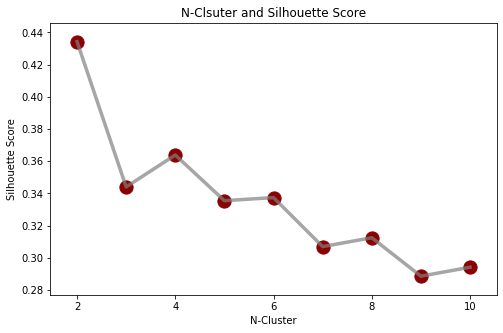

In [10]:
sils=[]

for k in range(2,11):
    km=KMeans(init='k-means++', n_clusters = k, n_init=100,random_state=101)
    km.fit(X_sc)
    sils.append(silhouette_score(X_sc,km.labels_,metric='euclidean'))
    silhouette_avg = silhouette_score(X_sc,km.labels_)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)

    
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(range(2,11),sils,c='grey',lw=3.5,alpha=0.7)
ax.scatter(range(2,11),sils,c='darkred',s=175)

plt.title('N-Clsuter and Silhouette Score')
plt.xlabel('N-Cluster')
plt.ylabel('Silhouette Score')
plt.show()

For n_clusters = 2 The wcss is : 8518.587966422097
For n_clusters = 3 The wcss is : 6329.500756860086
For n_clusters = 4 The wcss is : 4921.112823490689
For n_clusters = 5 The wcss is : 4152.747252228449
For n_clusters = 6 The wcss is : 3579.107154444541
For n_clusters = 7 The wcss is : 3225.1206911356203
For n_clusters = 8 The wcss is : 2921.0984000496246
For n_clusters = 9 The wcss is : 2703.8319313936863
For n_clusters = 10 The wcss is : 2506.290858274407


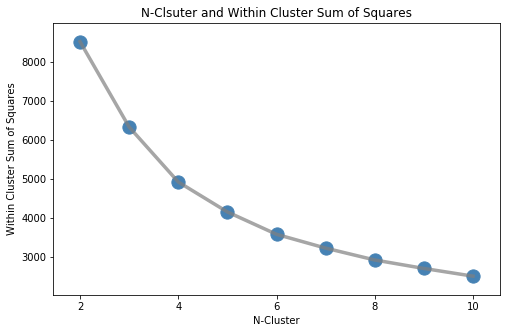

In [11]:
wcss=[]

for k in range(2,11):
    km=KMeans(init='k-means++', n_clusters = k, n_init=100,random_state=101)
    km.fit(X_sc)
    wcss.append(km.inertia_)
    
    print("For n_clusters =", k, "The wcss is :", km.inertia_)
    
fig, ax=plt.subplots(figsize=(8,5))
ax.plot(range(2,11),wcss,c='grey',lw=3.5,alpha=0.7)
ax.scatter(range(2,11),wcss,c='steelblue',s=175)
plt.title('N-Clsuter and Within Cluster Sum of Squares')
plt.xlabel('N-Cluster')
plt.ylabel('Within Cluster Sum of Squares')

plt.show()

In [12]:
scores = []
for k in range(2, 11):
    cl = KMeans(init='k-means++', n_clusters = k, n_init=100,random_state=101)
    cl.fit(X_sc)
    inertia = cl.inertia_
    
    sil = silhouette_score(X_sc, cl.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']
score_df

,k,inertia,silhouette
0,2,8518.59,0.43
1,3,6329.50,0.34
2,4,4921.11,0.36
3,5,4152.75,0.34
4,6,3579.11,0.34
5,7,3225.12,0.31
6,8,2921.10,0.31
7,9,2703.83,0.29
8,10,2506.29,0.29


<font color=darkblue> From the above 2 diagrams, k=4 is the optimum choice where the silhoutte score is highest 0.3796 and the drop wcss after k=4 is less prominent.<br>

### Fitting K= 3 in to KMeans

In [13]:
# Fitting K-Means to the dataset
km = KMeans(n_clusters = 3, init = 'k-means++',random_state=101)
label = km.fit_predict(X_sc)

In [14]:
datadf_3=rfm_data.copy()
datadf_3['Cluster']=label
datadf_3.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.00,326,12,77556.46,1
12347.00,3,8,4921.53,1
12348.00,76,5,2019.40,0
12349.00,19,4,4428.69,1
12350.00,311,1,334.40,2


In [15]:
centroids=pd.DataFrame(sc.inverse_transform(km.cluster_centers_),columns=['Recency','Frequency','Monetary'])
centroids

,Recency,Frequency,Monetary
0,4.28,1.34,7.04
1,2.64,2.61,8.57
2,5.62,0.24,5.56


In [16]:
grouped_clustter_3=datadf_3.groupby(['Cluster']).agg({'Recency':'mean',
                                             'Frequency':'mean',
                                             'Monetary':'mean',
                                             'Cluster':'count'})
grouped_clustter_3

,Recency,Frequency,Monetary,Cluster
Cluster,,,,
0,137.95,4.37,1484.92,2340
1,28.56,18.24,10124.64,1296
2,368.76,1.38,347.26,2242


In [17]:
data_normalized=pd.DataFrame(X_sc,
                            index=rfm_data.index,
                            columns=rfm_data.columns)
data_normalized['Cluster']=datadf_3['Cluster']
data_normalized.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.00,0.85,1.25,3.20,1
12347.00,-2.09,0.85,1.21,1
12348.00,-0.06,0.40,0.57,0
12349.00,-0.93,0.18,1.14,1
12350.00,0.82,-1.17,-0.72,2


In [18]:
rfm_k3data_melt=pd.melt(data_normalized.reset_index(),
                 id_vars=['Customer ID','Cluster'],
                 value_vars=['Recency','Frequency','Monetary'],
                 var_name='Attribute',
                  value_name='Value')
rfm_k3data_melt.head()

,Customer ID,Cluster,Attribute,Value
0,12346.00,1,Recency,0.85
1,12347.00,1,Recency,-2.09
2,12348.00,0,Recency,-0.06
3,12349.00,1,Recency,-0.93
4,12350.00,2,Recency,0.82


snake plot
- Market Research technque to compare different segments
- Visual representation of each segments attributes
- Need to first normalize data (center and scaled)
- Plot each cluster's average normalized values of each attributes

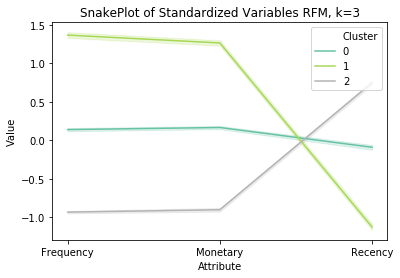

In [19]:
plt.title('SnakePlot of Standardized Variables RFM, k=3')
rfmk3=sns.lineplot(x='Attribute',y='Value',hue='Cluster',data=rfm_k3data_melt,legend='full',palette='Set2')

In [20]:
cluster_avg=datadf_3.groupby(['Cluster']).mean()
population_avg=datadf_3.mean()
rfm3_relative_imp=(cluster_avg/population_avg)-1

the further a ratio is from 0, the more important that attribute is for a segment relative to the total population


In [21]:
rfm3_relative_imp.round(2)
rfm3_relative_imp.drop('Cluster',axis=1,inplace=True)

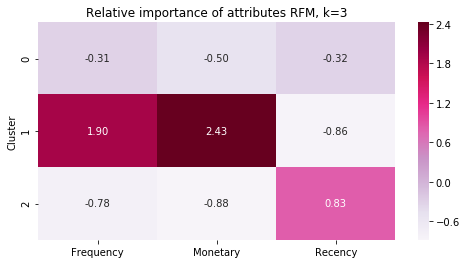

In [22]:
plt.figure(figsize=(8,4))
plt.title('Relative importance of attributes RFM, k=3')
sns.heatmap(data=rfm3_relative_imp,annot=True,
           fmt='.2f',cmap='PuRd');

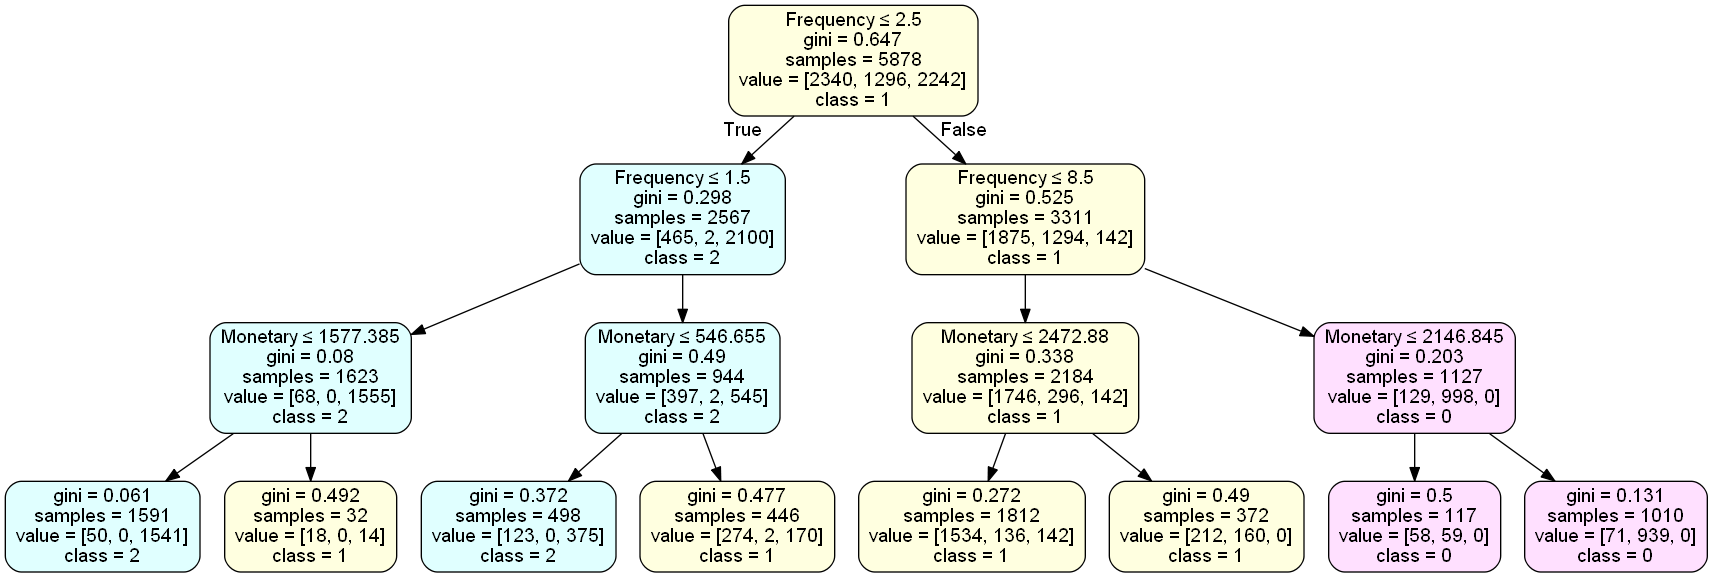

In [23]:
datadf_3['Cluster']=datadf_3["Cluster"].apply(str)

dt = tree.DecisionTreeClassifier(random_state = 101,max_depth=3)  
dt = dt.fit(datadf_3.iloc[:,1:3],datadf_3.iloc[:,3])

import pydotplus  
dot_data = tree.export_graphviz(dt, out_file=None)  
graph2 = pydotplus.graph_from_dot_data(dot_data)  
graph2.write_pdf("../tree/tree.pdf")  

from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None,  
                     feature_names=list(datadf_3.iloc[:,1:3].columns),
                     class_names=list(set(datadf_3['Cluster'].values)),
                     filled=True, rounded=True,  # leaves_parallel=True, 
                     special_characters=True)  
graph2 = pydotplus.graph_from_dot_data(dot_data)

## Color of nodes
nodes = graph2.get_node_list()

for node in nodes:
    if node.get_label():
        values = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')];
        color = {0: [255,255,224], 1: [255,224,255], 2: [224,255,255],}
        values = color[values.index(max(values))]; # print(values)
        color = '#{:02x}{:02x}{:02x}'.format(values[0], values[1], values[2]); # print(color)
        node.set_fillcolor(color )

Image(graph2.create_png() ) 

### Fitting K= 4 in to KMeans

In [24]:
# Fitting K-Means to the dataset
km = KMeans(n_clusters = 4, init = 'k-means++',random_state=101)
label = km.fit_predict(X_sc)

In [25]:
datadf_4=rfm_data.copy()
datadf_4['Cluster']=label
datadf_4.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.00,326,12,77556.46,3
12347.00,3,8,4921.53,3
12348.00,76,5,2019.40,0
12349.00,19,4,4428.69,3
12350.00,311,1,334.40,1


In [26]:
centroids=pd.DataFrame(sc.inverse_transform(km.cluster_centers_),columns=['Recency','Frequency','Monetary'])
centroids

,Recency,Frequency,Monetary
0,5.21,1.48,7.28
1,5.77,0.20,5.48
2,3.01,0.98,6.51
3,2.70,2.66,8.64


In [27]:
grouped_clustter_4=datadf_4.groupby(['Cluster']).agg({'Recency':'mean',
                                             'Frequency':'mean',
                                             'Monetary':'mean',
                                             'Cluster':'count'})
grouped_clustter_4

,Recency,Frequency,Monetary,Cluster
Cluster,,,,
0,234.92,4.97,1866.54,1533
1,389.99,1.31,311.88,1948
2,28.09,3.07,837.08,1168
3,27.61,18.88,10519.25,1229


In [28]:
data_normalized=pd.DataFrame(X_sc,
                            index=rfm_data.index,
                            columns=rfm_data.columns)
data_normalized['Cluster']=datadf_4['Cluster']
data_normalized.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.00,0.85,1.25,3.20,3
12347.00,-2.09,0.85,1.21,3
12348.00,-0.06,0.40,0.57,0
12349.00,-0.93,0.18,1.14,3
12350.00,0.82,-1.17,-0.72,1


In [29]:
rfm_k4data_melt=pd.melt(data_normalized.reset_index(),
                 id_vars=['Customer ID','Cluster'],
                 value_vars=['Recency','Frequency','Monetary'],
                 var_name='Attribute',
                  value_name='Value')
rfm_k4data_melt.head()

,Customer ID,Cluster,Attribute,Value
0,12346.00,3,Recency,0.85
1,12347.00,3,Recency,-2.09
2,12348.00,0,Recency,-0.06
3,12349.00,3,Recency,-0.93
4,12350.00,1,Recency,0.82


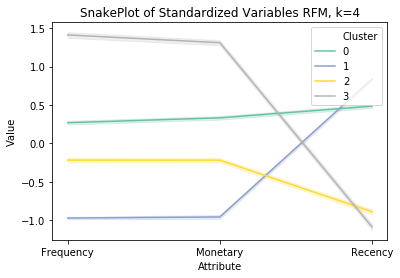

In [30]:
plt.title('SnakePlot of Standardized Variables RFM, k=4')
rfmk4=sns.lineplot(x='Attribute',y='Value',hue='Cluster',data=rfm_k4data_melt,legend='full',palette='Set2')

In [31]:
cluster_avg=datadf_4.groupby(['Cluster']).mean()
population_avg=datadf_4.mean()
rfm4_relative_imp=(cluster_avg/population_avg)-1

In [32]:
rfm4_relative_imp.round(2)
rfm4_relative_imp.drop('Cluster',axis=1,inplace=True)

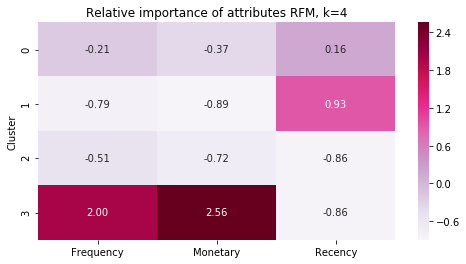

In [33]:
plt.figure(figsize=(8,4))
plt.title('Relative importance of attributes RFM, k=4')
sns.heatmap(data=rfm4_relative_imp,annot=True,
           fmt='.2f',cmap='PuRd');

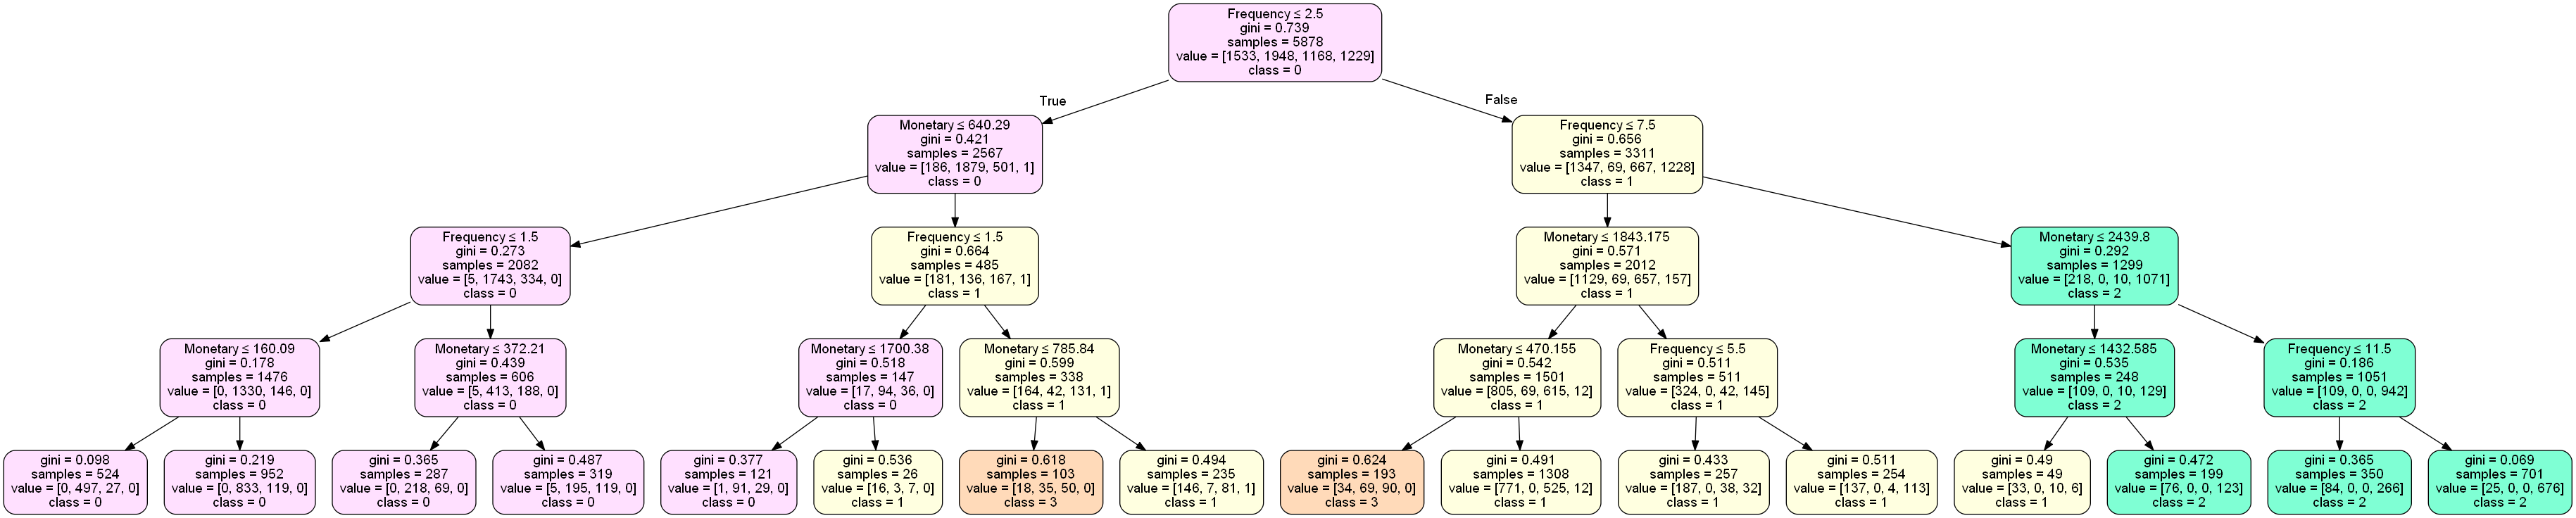

In [34]:
datadf_4['Cluster']=datadf_4["Cluster"].apply(str)

dt = tree.DecisionTreeClassifier(random_state = 101,max_depth=4)  
dt = dt.fit(datadf_4.iloc[:,1:3],datadf_4.iloc[:,3])

import pydotplus  
dot_data = tree.export_graphviz(dt, out_file=None)  
graph2 = pydotplus.graph_from_dot_data(dot_data)  
graph2.write_pdf("../tree/tree.pdf")  

from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None,  
                     feature_names=list(datadf_4.iloc[:,1:3].columns),
                     class_names=list(set(datadf_4['Cluster'].values)),
                     filled=True, rounded=True,  # leaves_parallel=True, 
                     special_characters=True)  
graph2 = pydotplus.graph_from_dot_data(dot_data)

## Color of nodes
nodes = graph2.get_node_list()

for node in nodes:
    if node.get_label():
        values = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')];
        color = {0: [255,255,224], 1: [255,224,255], 2: [255,218,185],3: [127,255,212],}
        values = color[values.index(max(values))]; # print(values)
        color = '#{:02x}{:02x}{:02x}'.format(values[0], values[1], values[2]); # print(color)
        node.set_fillcolor(color )

Image(graph2.create_png() ) 

### Fitting K= 5 in to KMeans

In [35]:
# Fitting K-Means to the dataset
km = KMeans(n_clusters = 5, init = 'k-means++',random_state=101)
label = km.fit_predict(X_sc)

In [36]:
datadf_5=rfm_data.copy()
datadf_5['Cluster']=label
datadf_5.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.00,326,12,77556.46,3
12347.00,3,8,4921.53,1
12348.00,76,5,2019.40,3
12349.00,19,4,4428.69,3
12350.00,311,1,334.40,2


In [37]:
centroids=pd.DataFrame(sc.inverse_transform(km.cluster_centers_),columns=['Recency','Frequency','Monetary'])
centroids

,Recency,Frequency,Monetary
0,5.55,1.15,6.89
1,1.90,3.03,9.08
2,5.84,0.12,5.33
3,3.79,2.12,7.99
4,3.03,0.85,6.37


In [38]:
grouped_clustter_5=datadf_5.groupby(['Cluster']).agg({'Recency':'mean',
                                             'Frequency':'mean',
                                             'Monetary':'mean',
                                             'Cluster':'count'})
grouped_clustter_5

,Recency,Frequency,Monetary,Cluster
Cluster,,,,
0,300.97,3.51,1212.96,1361
1,11.29,27.75,17115.55,573
2,407.59,1.18,257.32,1609
3,66.55,9.19,3773.25,1249
4,29.04,2.69,727.37,1086


In [39]:
data_normalized=pd.DataFrame(X_sc,
                            index=rfm_data.index,
                            columns=rfm_data.columns)
data_normalized['Cluster']=datadf_5['Cluster']
data_normalized.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.00,0.85,1.25,3.20,3
12347.00,-2.09,0.85,1.21,1
12348.00,-0.06,0.40,0.57,3
12349.00,-0.93,0.18,1.14,3
12350.00,0.82,-1.17,-0.72,2


In [40]:
rfm_k5data_melt=pd.melt(data_normalized.reset_index(),
                 id_vars=['Customer ID','Cluster'],
                 value_vars=['Recency','Frequency','Monetary'],
                 var_name='Attribute',
                  value_name='Value')
rfm_k5data_melt.head()

,Customer ID,Cluster,Attribute,Value
0,12346.00,3,Recency,0.85
1,12347.00,1,Recency,-2.09
2,12348.00,3,Recency,-0.06
3,12349.00,3,Recency,-0.93
4,12350.00,2,Recency,0.82


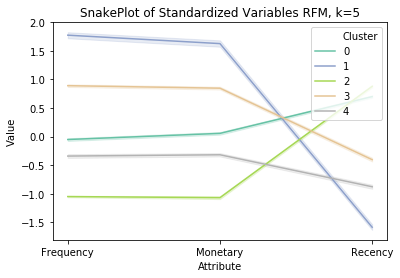

In [41]:
plt.title('SnakePlot of Standardized Variables RFM, k=5')
rfmk5=sns.lineplot(x='Attribute',y='Value',hue='Cluster',data=rfm_k5data_melt,legend='full',palette='Set2')

In [42]:
cluster_avg=datadf_5.groupby(['Cluster']).mean()
population_avg=datadf_5.mean()
rfm5_relative_imp=(cluster_avg/population_avg)-1

In [43]:
rfm5_relative_imp.round(2)
rfm5_relative_imp.drop('Cluster',axis=1,inplace=True)

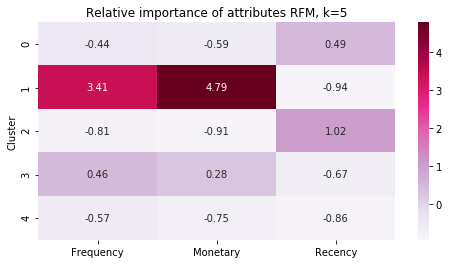

In [44]:
plt.figure(figsize=(8,4))
plt.title('Relative importance of attributes RFM, k=5')
sns.heatmap(data=rfm5_relative_imp,annot=True,
           fmt='.2f',cmap='PuRd');

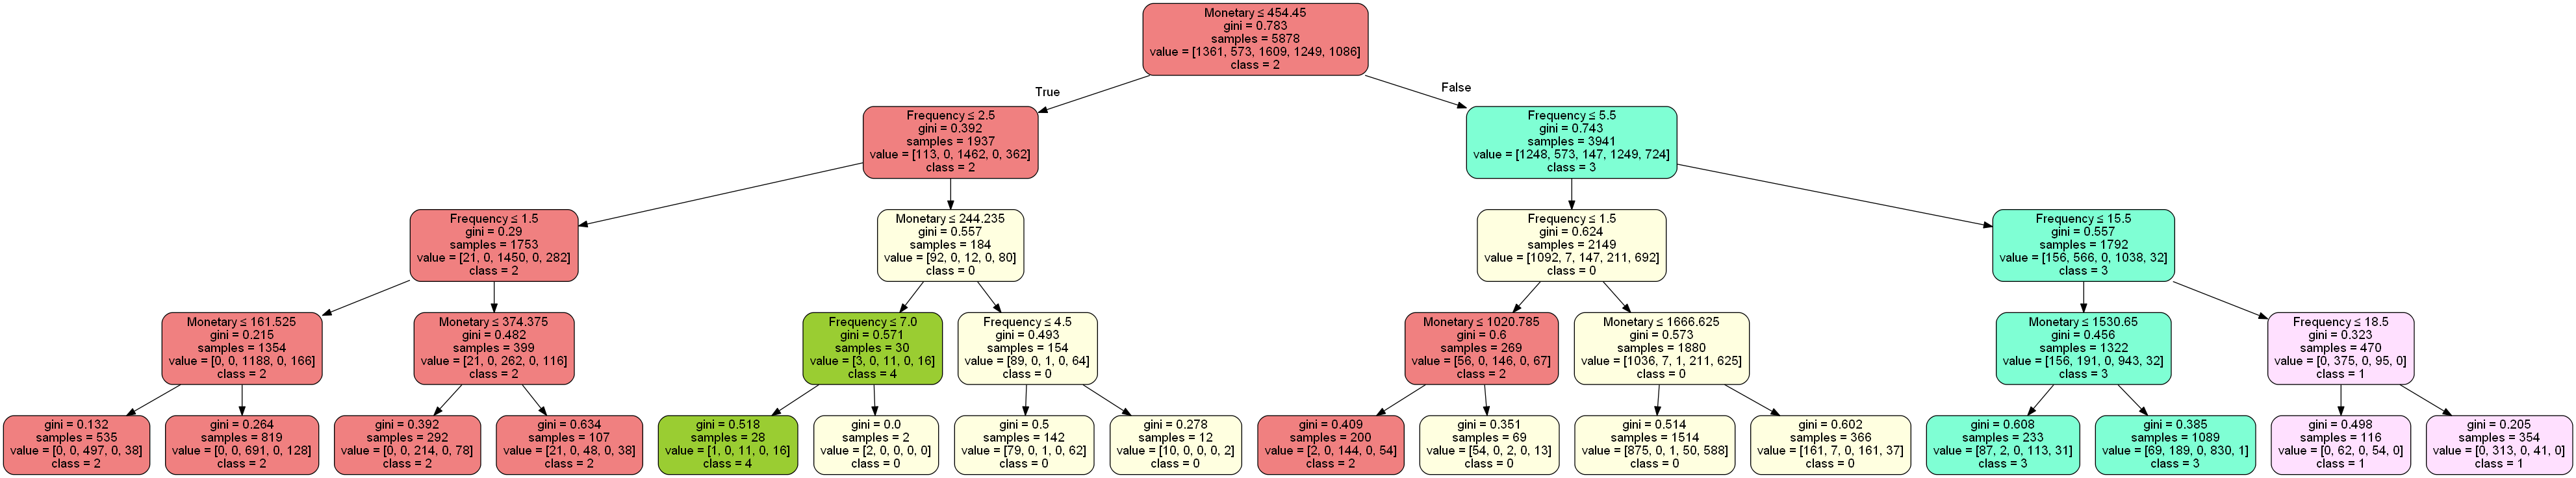

In [45]:
datadf_5['Cluster']=datadf_5["Cluster"].apply(str)

dt = tree.DecisionTreeClassifier(random_state = 101,max_depth=4)  
dt = dt.fit(datadf_5.iloc[:,1:3],datadf_5.iloc[:,3])

import pydotplus  
dot_data = tree.export_graphviz(dt, out_file=None)  
graph2 = pydotplus.graph_from_dot_data(dot_data)  
graph2.write_pdf("../tree/tree.pdf")  

from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None,  
                     feature_names=list(datadf_5.iloc[:,1:3].columns),
                     class_names=list(set(datadf_5['Cluster'].values)),
                     filled=True, rounded=True,  # leaves_parallel=True, 
                     special_characters=True)  
graph2 = pydotplus.graph_from_dot_data(dot_data)

## Color of nodes
nodes = graph2.get_node_list()

for node in nodes:
    if node.get_label():
        values = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')];
        color = {0: [255,255,224], 1: [255,224,255], 2: [240,128,128],3: [127,255,212],4: [154,205,50],}
        values = color[values.index(max(values))]; # print(values)
        color = '#{:02x}{:02x}{:02x}'.format(values[0], values[1], values[2]); # print(color)
        node.set_fillcolor(color )

Image(graph2.create_png() ) 

### Fitting K= 6 in to KMeans

In [46]:
# Fitting K-Means to the dataset
km = KMeans(n_clusters = 6, init = 'k-means++',random_state=101)
label = km.fit_predict(X_sc)

In [47]:
datadf_6=rfm_data.copy()
datadf_6['Cluster']=label
datadf_6.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.00,326,12,77556.46,5
12347.00,3,8,4921.53,3
12348.00,76,5,2019.40,5
12349.00,19,4,4428.69,2
12350.00,311,1,334.40,4


In [48]:
centroids=pd.DataFrame(sc.inverse_transform(km.cluster_centers_),columns=['Recency','Frequency','Monetary'])
centroids

,Recency,Frequency,Monetary
0,5.50,1.16,6.89
1,3.62,0.41,5.82
2,2.50,1.53,7.17
3,1.97,3.14,9.22
4,6.01,0.13,5.34
5,4.12,2.21,8.15


In [49]:
grouped_clustter_6=datadf_6.groupby(['Cluster']).agg({'Recency':'mean',
                                             'Frequency':'mean',
                                             'Monetary':'mean',
                                             'Cluster':'count'})
grouped_clustter_6

,Recency,Frequency,Monetary,Cluster
Cluster,,,,
0,291.52,3.51,1191.67,1360
1,46.64,1.66,416.59,757
2,17.07,5.12,1530.22,828
3,11.82,30.17,18887.08,507
4,445.61,1.19,263.11,1463
5,85.93,10.03,4372.87,963


In [50]:
data_normalized=pd.DataFrame(X_sc,
                            index=rfm_data.index,
                            columns=rfm_data.columns)
data_normalized['Cluster']=datadf_6['Cluster']
data_normalized.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.00,0.85,1.25,3.20,5
12347.00,-2.09,0.85,1.21,3
12348.00,-0.06,0.40,0.57,5
12349.00,-0.93,0.18,1.14,2
12350.00,0.82,-1.17,-0.72,4


In [51]:
rfm_k6data_melt=pd.melt(data_normalized.reset_index(),
                 id_vars=['Customer ID','Cluster'],
                 value_vars=['Recency','Frequency','Monetary'],
                 var_name='Attribute',
                  value_name='Value')
rfm_k6data_melt.head()

,Customer ID,Cluster,Attribute,Value
0,12346.00,5,Recency,0.85
1,12347.00,3,Recency,-2.09
2,12348.00,5,Recency,-0.06
3,12349.00,2,Recency,-0.93
4,12350.00,4,Recency,0.82


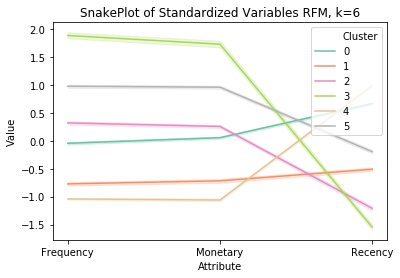

In [52]:
plt.title('SnakePlot of Standardized Variables RFM, k=6')
rfmk6=sns.lineplot(x='Attribute',y='Value',hue='Cluster',data=rfm_k6data_melt,legend='full',palette='Set2')

In [53]:
cluster_avg=datadf_6.groupby(['Cluster']).mean()
population_avg=datadf_6.mean()
rfm6_relative_imp=(cluster_avg/population_avg)-1

In [54]:
rfm6_relative_imp.round(2)
rfm6_relative_imp.drop('Cluster',axis=1,inplace=True)

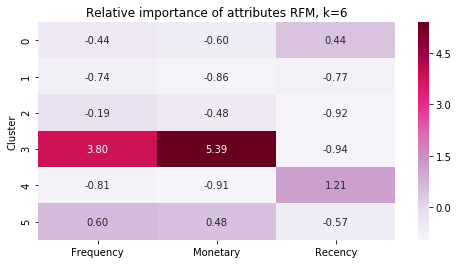

In [55]:
plt.figure(figsize=(8,4))
plt.title('Relative importance of attributes RFM, k=6')
sns.heatmap(data=rfm6_relative_imp,annot=True,
           fmt='.2f',cmap='PuRd');

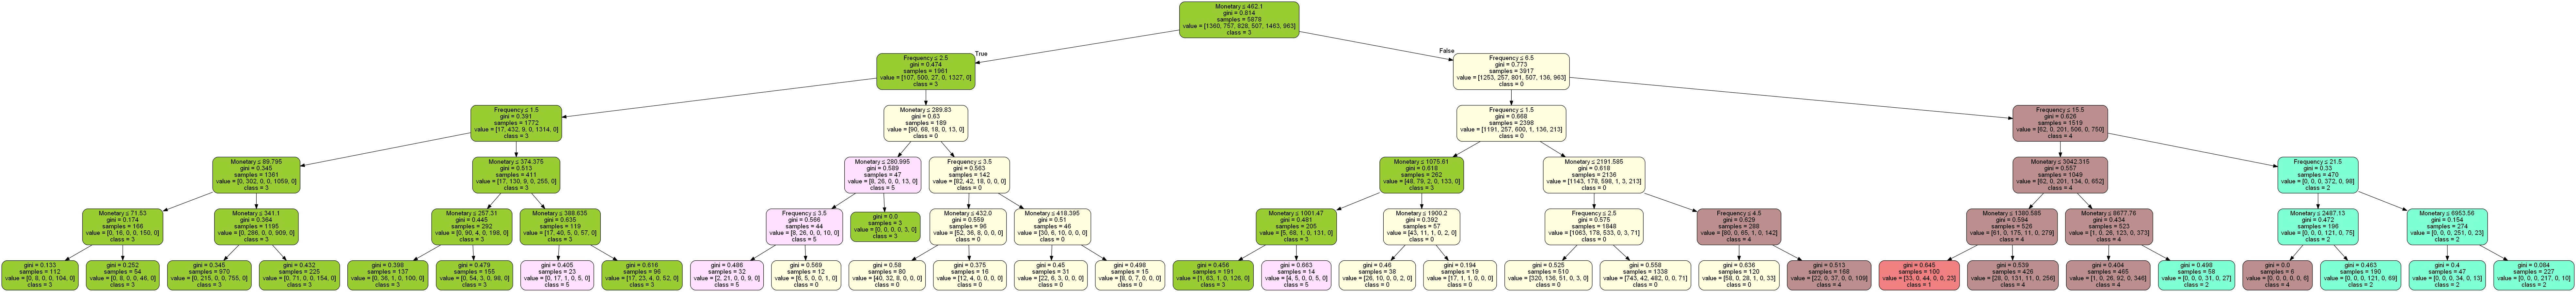

In [56]:
datadf_6['Cluster']=datadf_6["Cluster"].apply(str)

dt = tree.DecisionTreeClassifier(random_state = 101,max_depth=5)  
dt = dt.fit(datadf_6.iloc[:,1:3],datadf_6.iloc[:,3])

import pydotplus  
dot_data = tree.export_graphviz(dt, out_file=None)  
graph2 = pydotplus.graph_from_dot_data(dot_data)  
graph2.write_pdf("../tree/tree.pdf")  

from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None,  
                     feature_names=list(datadf_6.iloc[:,1:3].columns),
                     class_names=list(set(datadf_6['Cluster'].values)),
                     filled=True, rounded=True,  # leaves_parallel=True, 
                     special_characters=True)  
graph2 = pydotplus.graph_from_dot_data(dot_data)

## Color of nodes
nodes = graph2.get_node_list()

for node in nodes:
    if node.get_label():
        values = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')];
        color = {0: [255,255,224], 1: [255,224,255], 2: [240,128,128],3: [127,255,212],4: [154,205,50],5: [188,143,143],}
        values = color[values.index(max(values))]; # print(values)
        color = '#{:02x}{:02x}{:02x}'.format(values[0], values[1], values[2]); # print(color)
        node.set_fillcolor(color )

Image(graph2.create_png() ) 

### Fitting K= 7 in to KMeans

In [57]:
# Fitting K-Means to the dataset
km = KMeans(n_clusters = 7, init = 'k-means++',random_state=101)
label = km.fit_predict(X_sc)

In [58]:
datadf_7=rfm_data.copy()
datadf_7['Cluster']=label
datadf_7.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.00,326,12,77556.46,6
12347.00,3,8,4921.53,3
12348.00,76,5,2019.40,4
12349.00,19,4,4428.69,3
12350.00,311,1,334.40,2


In [59]:
centroids=pd.DataFrame(sc.inverse_transform(km.cluster_centers_),columns=['Recency','Frequency','Monetary'])
centroids

,Recency,Frequency,Monetary
0,1.62,3.34,9.40
1,5.80,0.78,6.49
2,6.02,0.06,5.16
3,2.39,1.54,7.17
4,4.95,1.63,7.41
5,3.61,0.43,5.86
6,3.57,2.46,8.47


In [60]:
grouped_clustter_7=datadf_7.groupby(['Cluster']).agg({'Recency':'mean',
                                             'Frequency':'mean',
                                             'Monetary':'mean',
                                             'Cluster':'count'})
grouped_clustter_7

,Recency,Frequency,Monetary,Cluster
Cluster,,,,
0,8.28,36.79,23955.73,344
1,363.73,2.37,781.22,1030
2,451.88,1.09,210.87,1196
3,15.09,5.14,1522.63,756
4,183.18,5.48,1954.55,998
5,45.77,1.70,437.25,772
6,49.96,12.65,5930.78,782


In [61]:
data_normalized=pd.DataFrame(X_sc,
                            index=rfm_data.index,
                            columns=rfm_data.columns)
data_normalized['Cluster']=datadf_7['Cluster']
data_normalized.head()

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.00,0.85,1.25,3.20,6
12347.00,-2.09,0.85,1.21,3
12348.00,-0.06,0.40,0.57,4
12349.00,-0.93,0.18,1.14,3
12350.00,0.82,-1.17,-0.72,2


In [62]:
rfm_k7data_melt=pd.melt(data_normalized.reset_index(),
                 id_vars=['Customer ID','Cluster'],
                 value_vars=['Recency','Frequency','Monetary'],
                 var_name='Attribute',
                  value_name='Value')
rfm_k7data_melt.head()

,Customer ID,Cluster,Attribute,Value
0,12346.00,6,Recency,0.85
1,12347.00,3,Recency,-2.09
2,12348.00,4,Recency,-0.06
3,12349.00,3,Recency,-0.93
4,12350.00,2,Recency,0.82


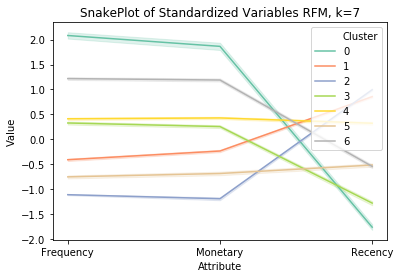

In [63]:
plt.title('SnakePlot of Standardized Variables RFM, k=7')
rfmk7=sns.lineplot(x='Attribute',y='Value',hue='Cluster',data=rfm_k7data_melt,legend='full',palette='Set2')

In [64]:
cluster_avg=datadf_7.groupby(['Cluster']).mean()
population_avg=datadf_7.mean()
rfm7_relative_imp=(cluster_avg/population_avg)-1

In [65]:
rfm7_relative_imp.round(2)
rfm7_relative_imp.drop('Cluster',axis=1,inplace=True)

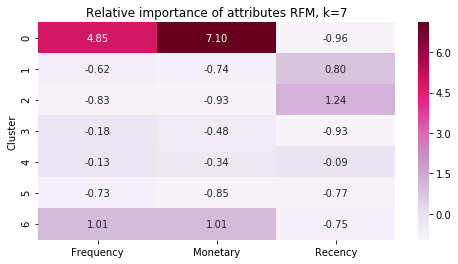

In [66]:
plt.figure(figsize=(8,4))
plt.title('Relative importance of attributes RFM, k=7')
sns.heatmap(data=rfm7_relative_imp,annot=True,
           fmt='.2f',cmap='PuRd');

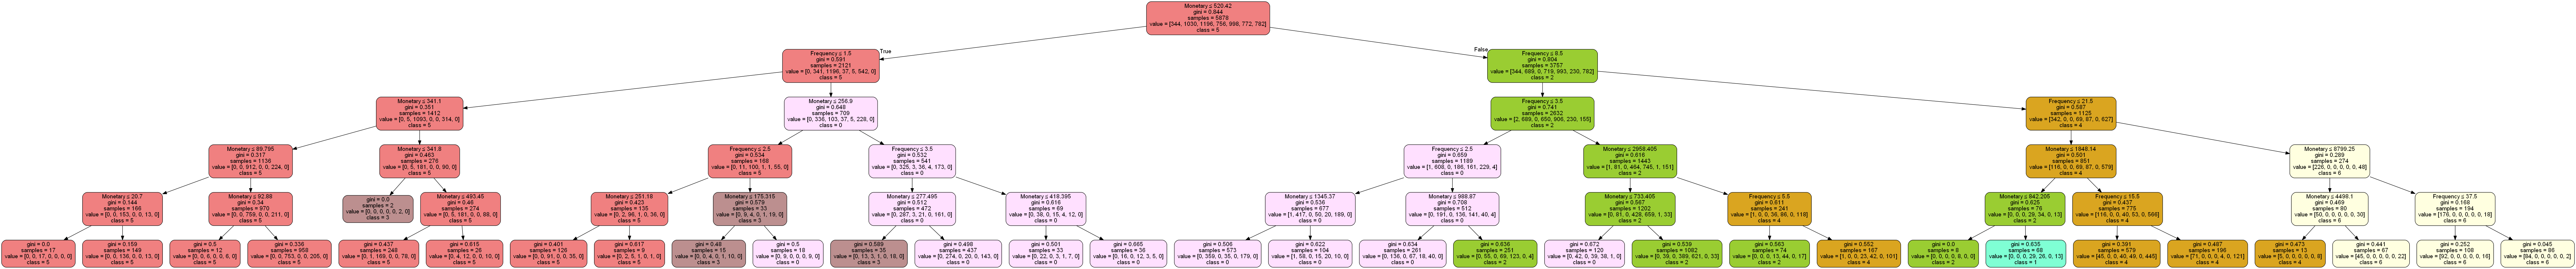

In [67]:
datadf_7['Cluster']=datadf_7["Cluster"].apply(str)

dt = tree.DecisionTreeClassifier(random_state = 101,max_depth=5)  
dt = dt.fit(datadf_7.iloc[:,1:3],datadf_7.iloc[:,3])

import pydotplus  
dot_data = tree.export_graphviz(dt, out_file=None)  
graph2 = pydotplus.graph_from_dot_data(dot_data)  
graph2.write_pdf("../tree/tree.pdf")  

from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None,  
                     feature_names=list(datadf_7.iloc[:,1:3].columns),
                     class_names=list(set(datadf_7['Cluster'].values)),
                     filled=True, rounded=True,  # leaves_parallel=True, 
                     special_characters=True)  
graph2 = pydotplus.graph_from_dot_data(dot_data)

## Color of nodes
nodes = graph2.get_node_list()

for node in nodes:
    if node.get_label():
        values = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')];
        color = {0: [255,255,224], 1: [255,224,255], 2: [240,128,128],3: [127,255,212],4: [154,205,50],5: [188,143,143],6: [218,165,32],}
        values = color[values.index(max(values))]; # print(values)
        color = '#{:02x}{:02x}{:02x}'.format(values[0], values[1], values[2]); # print(color)
        node.set_fillcolor(color )

Image(graph2.create_png() ) 

http://webgraphviz.com/

https://www.html.am/html-codes/color/color-scheme.cfm?rgbColor=255,255,224